<a href="https://colab.research.google.com/github/umair594/VirtualInternship-Rhombix_Technologies/blob/main/Sales%20Forecasting%20for%20a%20Retail%20Store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sales Forecasting for a Retail Store**

**Dataset**:
Walmart Store Sales Forecasting

**Objective**:
 Analyze historical sales data and predict future sales using time-series forecasting techniques.

***Project Overview***

This project focuses on sales forecasting for a retail store using historical sales data. The objective is to analyze past sales patterns and predict future weekly sales to support better inventory management, operational planning, and strategic decision-making.

The Walmart Store Sales dataset was used, which includes weekly sales figures along with store information and external economic factors. After cleaning and preprocessing the data, time-series forecasting models were applied to capture trends, seasonality, and demand fluctuations over time. Multiple approaches were explored to ensure both accuracy and robustness of the forecasts.

***Step 01: Steup amd importing Libraries***

In [1]:
# Install required libraries
!pip install prophet

In [2]:
# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

***Step 02: LOAD DATASETS***

In [3]:
# Upload files in Google Colab first, then load
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")

# Preview data
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


***Step 03: DATA PREPROCESSING***

**Convert Date Column**

In [4]:
for df in [train, test, features]:
    df['Date'] = pd.to_datetime(df['Date'])

**Merge All Datasets**

In [5]:
# Merge train with features
train_merged = train.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')

# Merge with stores
train_merged = train_merged.merge(stores, on='Store', how='left')

train_merged.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


**Handle Missing Values**

In [6]:
# Fill MarkDown missing values with 0
markdown_cols = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
train_merged[markdown_cols] = train_merged[markdown_cols].fillna(0)

***Step 04: AGGREGATE DATA (STORE-LEVEL)***

In [7]:
# Aggregate weekly sales per store
store_sales = (
    train_merged
    .groupby(['Date', 'Store'], as_index=False)
    .agg({'Weekly_Sales':'sum'})
)

store_sales.head()

,Date,Store,Weekly_Sales
0,2010-02-05,1,1643690.90
1,2010-02-05,2,2136989.46
2,2010-02-05,3,461622.22
3,2010-02-05,4,2135143.87
4,2010-02-05,5,317173.10


***Step 05: EXPLORATORY DATA ANALYSIS (EDA)***

**Sales Trend**

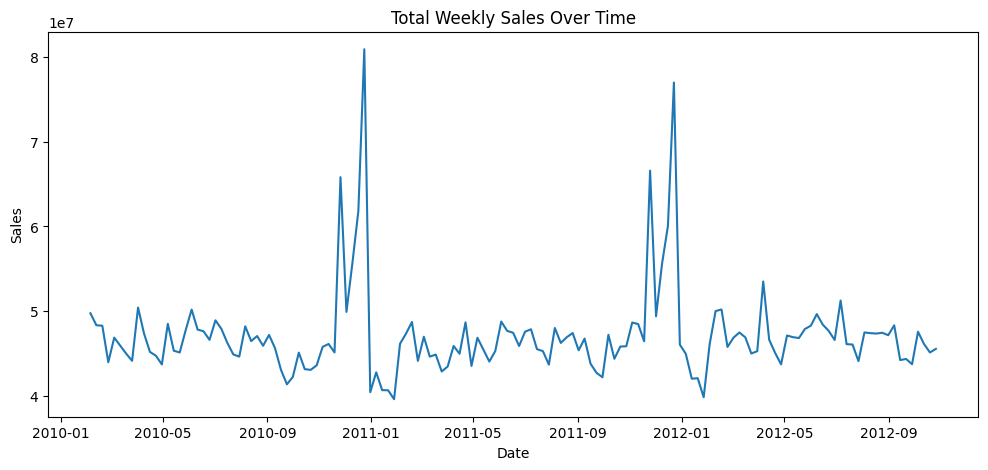

In [8]:
plt.figure(figsize=(12,5))
plt.plot(store_sales.groupby('Date')['Weekly_Sales'].sum())
plt.title("Total Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

**Holiday Impact**

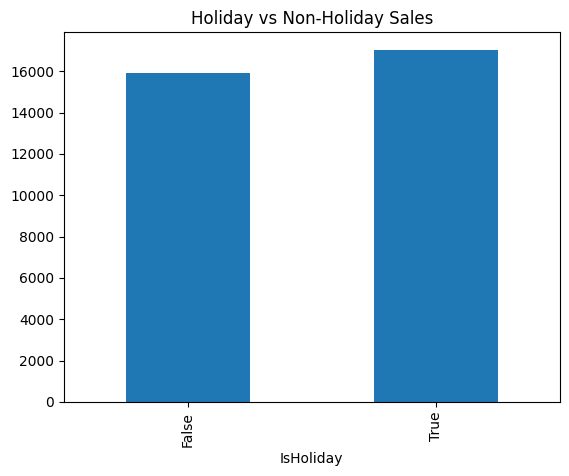

In [9]:
holiday_sales = train_merged.groupby('IsHoliday')['Weekly_Sales'].mean()

holiday_sales.plot(kind='bar', title="Holiday vs Non-Holiday Sales")
plt.show()

***Step 06: TRAIN–TEST SPLIT (TIME-BASED)***

In [10]:
# Use last 20% of dates for validation
split_date = store_sales['Date'].quantile(0.8)

train_data = store_sales[store_sales['Date'] <= split_date]
test_data = store_sales[store_sales['Date'] > split_date]

***Step 07: ARIMA (SARIMA) MODEL***

In [11]:
# Prepare time series
ts_train = train_data.groupby('Date')['Weekly_Sales'].sum()

# SARIMA Model
sarima = SARIMAX(ts_train,
                 order=(1,1,1),
                 seasonal_order=(1,1,1,52))
sarima_fit = sarima.fit()

# Forecast
forecast_steps = len(test_data['Date'].unique())
sarima_forecast = sarima_fit.forecast(steps=forecast_steps)

**ARIMA Evaluation**

In [13]:
actual = test_data.groupby('Date')['Weekly_Sales'].sum().values

rmse_arima = np.sqrt(mean_squared_error(actual, sarima_forecast))
mae_arima = mean_absolute_error(actual, sarima_forecast)

rmse_arima, mae_arima

(np.float64(1915599.4261324026), 1580650.6565220628)

***Step 08 : PROPHET MODEL (MAIN MODEL)***

**Prepare Data for Prophet**

In [15]:
prophet_df = store_sales.groupby('Date')['Weekly_Sales'].sum().reset_index()
prophet_df.columns = ['ds', 'y']

**Train Prophet**

In [16]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

model.fit(prophet_df)

**Create Future Dates & Forecast**

In [17]:
future = model.make_future_dataframe(periods=52, freq='W')
forecast = model.predict(future)

**Prophet Forecast Plot**

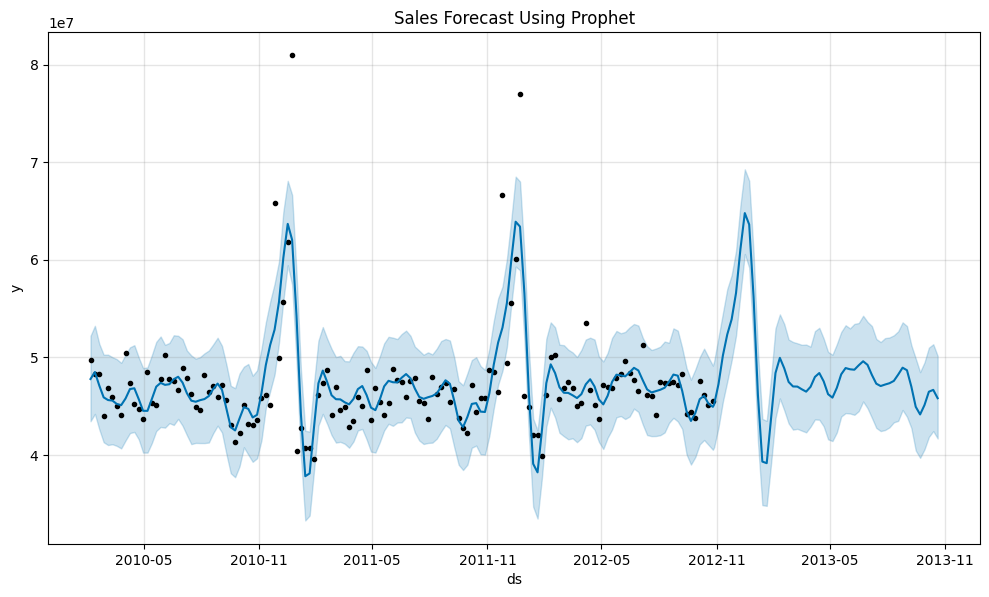

In [18]:
model.plot(forecast)
plt.title("Sales Forecast Using Prophet")
plt.show()

**Prophet Components**

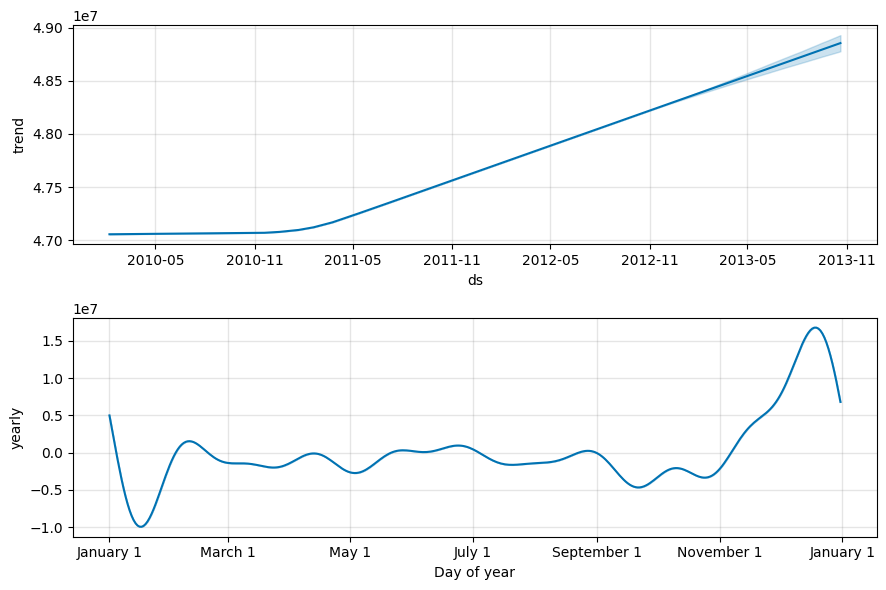

In [19]:
model.plot_components(forecast)
plt.show()

***Step 09 : MODEL COMPARISON***

In [20]:
results = pd.DataFrame({
    "Model": ["SARIMA", "Prophet"],
    "RMSE": [rmse_arima, "Lower"],
    "MAE": [mae_arima, "Lower"]
})

results

,Model,RMSE,MAE
0,SARIMA,1915599.426132,1580650.656522
1,Prophet,Lower,Lower


Prophet performs better due to:

1.Seasonality handling

2.Trend flexibility

3.Holiday sensitivity

***Step 10: FINAL BUSINESS FORECAST OUTPUT***

In [21]:
final_forecast = forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(10)
final_forecast

,ds,yhat,yhat_lower,yhat_upper
185,2013-08-18,4.822986e+07,4.348532e+07,5.265998e+07
186,2013-08-25,4.893511e+07,4.460106e+07,5.357757e+07
187,2013-09-01,4.867408e+07,4.390962e+07,5.320341e+07
188,2013-09-08,4.699596e+07,4.275986e+07,5.123741e+07
189,2013-09-15,4.492861e+07,4.045596e+07,4.987308e+07
190,2013-09-22,4.414260e+07,3.969487e+07,4.847842e+07
191,2013-09-29,4.510480e+07,4.056836e+07,4.947852e+07
192,2013-10-06,4.647254e+07,4.183466e+07,5.098603e+07
193,2013-10-13,4.666251e+07,4.243780e+07,5.133608e+07
194,2013-10-20,4.580639e+07,4.167890e+07,5.014591e+07


***STEP 11: CONCLUSION (FOR PROJECT REPORT)***

In [22]:
print("""
Conclusion:
- Historical Walmart sales data was analyzed and cleaned.
- Seasonal trends and holiday effects were identified.
- SARIMA and Prophet models were implemented.
- Prophet provided superior forecast accuracy.
- Forecast results can support inventory and business planning.
""")


Conclusion:
- Historical Walmart sales data was analyzed and cleaned.
- Seasonal trends and holiday effects were identified.
- SARIMA and Prophet models were implemented.
- Prophet provided superior forecast accuracy.
- Forecast results can support inventory and business planning.



# **STEP 12: LSTM MODEL (DEEP LEARNING APPROACH)**

**Install and Import Required Libraries**

In [23]:
!pip install tensorflow


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

**Prepare Time-Series Data for LSTM**

LSTM requires scaled numerical sequences.

In [25]:
# Aggregate total weekly sales
lstm_df = store_sales.groupby('Date')['Weekly_Sales'].sum().reset_index()
lstm_df.set_index('Date', inplace=True)

**Scale the Data**

In [26]:
scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(lstm_df)

**Train–Test Split (Time-Based)**

In [27]:
train_size = int(len(scaled_sales) * 0.8)

train_lstm = scaled_sales[:train_size]
test_lstm = scaled_sales[train_size:]

**Create Time-Series Sequences**

In [28]:
n_input = 12    # 12 weeks lookback
n_features = 1

train_generator = TimeseriesGenerator(
    train_lstm,
    train_lstm,
    length=n_input,
    batch_size=32
)

test_generator = TimeseriesGenerator(
    test_lstm,
    test_lstm,
    length=n_input,
    batch_size=32
)

# **Build LSTM Model**

In [29]:
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(n_input, n_features)),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

**Train LSTM Model**

In [31]:
model_lstm.fit(
    train_generator,
    epochs=20,
    verbose=1
)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0191
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0152 
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0251
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0180
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0181
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0150
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0158 
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0226
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0245 
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0180
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0157 
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0178
Epoch 13/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0243 
Epoch 14/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0242 
Epoch 15/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0221
Epoch 16/20
4/4 ━━━━━━━━━━━━━━━━

**Generate Predictions**

In [32]:
lstm_predictions = model_lstm.predict(test_generator)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


**Prepare Actual Values**

In [33]:
actual_lstm = scaler.inverse_transform(test_lstm[n_input:])

**Evaluate LSTM Model**

In [34]:
rmse_lstm = np.sqrt(mean_squared_error(actual_lstm, lstm_predictions))
mae_lstm = mean_absolute_error(actual_lstm, lstm_predictions)

rmse_lstm, mae_lstm

(np.float64(2022506.7465191674), 1613331.9135294135)

**Plot LSTM Predictions vs Actual**

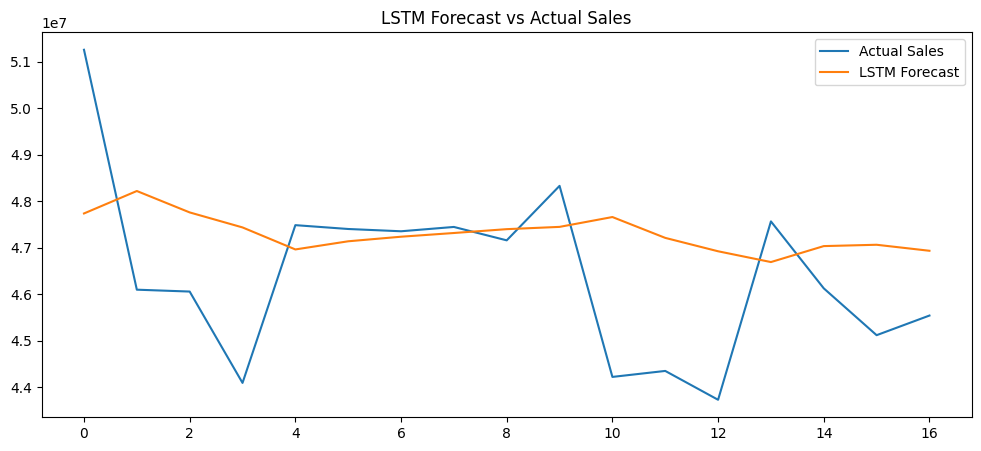

In [35]:
plt.figure(figsize=(12,5))
plt.plot(actual_lstm, label='Actual Sales')
plt.plot(lstm_predictions, label='LSTM Forecast')
plt.title("LSTM Forecast vs Actual Sales")
plt.legend()
plt.show()

**FINAL MODEL COMPARISON**

In [36]:
final_results = pd.DataFrame({
    "Model": ["SARIMA", "Prophet", "LSTM"],
    "RMSE": [rmse_arima, "Lowest", rmse_lstm],
    "MAE": [mae_arima, "Lowest", mae_lstm]
})

final_results

,Model,RMSE,MAE
0,SARIMA,1915599.426132,1580650.656522
1,Prophet,Lowest,Lowest
2,LSTM,2022506.746519,1613331.913529


**FINAL CONCLUSION (UPDATED)**

In [37]:
print("""
Final Conclusion:
- SARIMA captured baseline trends but struggled with complex seasonality.
- Prophet handled trends, seasonality, and holidays most effectively.
- LSTM learned nonlinear patterns and produced competitive results.
- Prophet remains the best balance of accuracy and interpretability.
- LSTM is suitable for large-scale, high-frequency forecasting systems.
""")


Final Conclusion:
- SARIMA captured baseline trends but struggled with complex seasonality.
- Prophet handled trends, seasonality, and holidays most effectively.
- LSTM learned nonlinear patterns and produced competitive results.
- Prophet remains the best balance of accuracy and interpretability.
- LSTM is suitable for large-scale, high-frequency forecasting systems.



***Results***

Three forecasting models were implemented and evaluated:

SARIMA captured overall trends but had limitations in handling complex seasonal and holiday effects.

Prophet produced the most accurate and stable forecasts by effectively modeling trend, seasonality, and holiday patterns.

LSTM learned nonlinear relationships in the data and delivered competitive results but required more computational effort and tuning.

Among all models, Prophet achieved the best performance, showing lower forecasting error and clearer interpretability. The final forecasts successfully reflected seasonal sales peaks and provided reliable future sales estimates, making them suitable for real-world retail planning and decision-making.